In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import multiprocessing as mul
from scipy import stats
import pickle
from scipy.integrate import quad
from corner import corner
import pandas as pd
import dynesty as dyn

In [2]:
pwd

'/scratch/Project-QG/task3'

In [3]:
GRBs = ['GRB210619B', 'GRB210610B', 'GRB210204A', 'GRB201216C', 'GRB200829A', 'GRB200613A', 'GRB190114C', 'GRB180720B', 'GRB180703A', 'GRB171010A', 'GRB160625B', 'GRB160509A', 'GRB150821A', 'GRB150514A', 'GRB150403A', 'GRB150314A', 'GRB141028A', 'GRB140508A', 'GRB140206A', 'GRB131231A', 'GRB131108A', 'GRB130925A', 'GRB130518A', 'GRB130427A', 'GRB120119A', 'GRB100728A', 'GRB091003A', 'GRB090926A', 'GRB090618', 'GRB090328', 'GRB081221', 'GRB080916C']

#### Agarwal Null Hypo error

$\quad \dfrac{d\Delta t_{int}}{dE} = (1 + z)\tau\dfrac{E}{keV}^{\alpha - 1}$


#### L.I.V error

$\quad \dfrac{d\Delta t_{LIV}}{dE} = \dfrac{1 + n}{2H_0}\cdot\dfrac{n E^{n-1}}{E_{QG}^{n}} {\huge \int}  _{0}^{z} \quad \dfrac{\left(1+z^{\prime}\right)^{n} d z^{\prime}}{\sqrt{\Omega_{\mathrm{m}}\left(1+z^{\prime}\right)^{3}+\Omega_{\Lambda}}}$


#### Total error
$\quad \dfrac{d(\Delta t_{int} + \Delta t_{LIV})}{dE}$


In [4]:
grb = 'GRB131231A'

grbname = grb + '.txt'
grbname_wtht_ext = grbname.replace('.txt','')
grbparam = pd.read_csv('../data/GRBPARAM.csv', index_col=0)

arr = np.loadtxt('../data/asciidataof_fig1/32lag/'+grbname)
data = [arr[:,0], arr[:,1], arr[:,2]]
x = arr[:,0]
y = arr[:,1]
yerr = arr[:,2]
df = pd.read_csv('../data/32lag_err/' + grb + '.txt', sep='\s+', header=None, names=['E_obs', 'E_obs_err', 'lag', 'lag_err'])
E_err = df['E_obs_err'].values

#Properties of GRB
E0 = grbparam[grbname.replace('.txt','')].E0
E0rest = E0
Erest = arr[:,0]    #in keV
z_com = grbparam[grbname.replace('.txt','')].redshift #redshift
H0=67.36 #Hubble constant km -1 Mpc s -1
omega_m = 0.315
omega_l = 1 - omega_m

lin_conv_fac = 3.0856 * 10**13
quad_conv_fac = 3.0856 * 10**7

def nullhp(E, alpha, tau):
    return (1 + z_com)*(tau * ((E ** alpha) - (E0 ** alpha)))
        


def int_z(z_prime, n):
    integ_fn = lambda z: (1+z)**n / np.sqrt(omega_m * (1+z)**3 + omega_l)
    return quad( integ_fn, a=0, b=z_prime)[0]

int_z1 = np.asarray(int_z(z_com, 1))
int_z2 = np.asarray(int_z(z_com, 2))

#LINEAR model
def linearhp(E, logEqg, alpha, tau):
    
    e0qg = (E - E0) / (10 ** logEqg)
    
    return (lin_conv_fac * e0qg * int_z1)/H0 + nullhp(E, alpha, tau)

#QUADRATIC model
def quadhp(E, logEqg, alpha, tau):
    e0qg = (E**2 - E0 **2) / ((10 ** logEqg)**2)
    
    return 1.5 * (quad_conv_fac * e0qg * int_z2)/H0 + nullhp(E, alpha, tau)


#LOG-LIKELIHOODS
def loglike_null(theta):
    alpha, tau = theta
    
    
    model = nullhp(x,  alpha, tau)
    
    return sum(stats.norm.logpdf(*args) for args in zip(y,model,yerr))
    
    

def loglike_linear(theta):
    logEqg, alpha, tau = theta
    
    model = linearhp(x, logEqg, alpha, tau)
    
    return sum(stats.norm.logpdf(*args) for args in zip(y,model,yerr))

def loglike_quad(theta):
    logEqg, alpha, tau = theta
    
    model = quadhp(x, logEqg, alpha, tau)
    
    return sum(stats.norm.logpdf(*args) for args in zip(y,model,yerr))


#PRIORS

alphamin = -2
alphamax = 1
taumin = -15
taumax = 10
logeqmin = 0
logeqmax = 20


#PRIOR DISTRIBUTIONS

def prior_transform_null(theta):
    alpha, tau = theta
    return [(alphamax - alphamin) * alpha + alphamin, (taumax - taumin) * tau + taumin]

def prior_transform_linear(theta):
    logEqg, alpha, tau = theta
    return [(logeqmax - logeqmin) * logEqg + logeqmin, (alphamax - alphamin) * alpha + alphamin, (taumax - taumin) * tau + taumin]

def prior_transform_quadratic(theta):
    logEqg, alpha, tau = theta
    return [(logeqmax - logeqmin) * logEqg + logeqmin, (alphamax - alphamin) * alpha + alphamin, (taumax - taumin) * tau + taumin]

In [5]:
#agarwal22:


def ddeltatdE_int(E, alpha, tau):
    uncertainity_int = (1 + z_com)*(tau * alpha* (E ** (alpha - 1)))
    return uncertainity_int * nullhp(E, alpha, tau)

def ddeltatdE_LIV_lin(E, logEqg, alpha, tau):
    de0qg = 1 / (10 ** logEqg)
    null_err = ddeltatdE_int(E, alpha, tau)
    
    uncertainity_LIV = (lin_conv_fac * de0qg * int_z1)/H0
    
    return uncertainity_LIV + null_err

def ddeltatdE_LIV_quad(E, logEqg, alpha, tau):
    de0qg = 2 * E / ((10 ** logEqg)**2)
    
    null_err = ddeltatdE_int(E, alpha, tau)
    uncertainity_LIV = 1.5*(quad_conv_fac * de0qg * int_z2)/H0
    
    return uncertainity_LIV + null_err


def chi2_all_hypo(E, E_err, y, yerr, n, alpha, tau, logEqg = 0):
    
    if n == 0:
        err = np.sqrt(yerr**2 + (ddeltatdE_int(E, alpha, tau) * E_err)**2)
        return np.sum(((y - nullhp(E, alpha, tau))/err)**2)/(len(y) - 2)
    
    elif n == 1:
        err = np.sqrt(yerr**2 + (ddeltatdE_LIV_lin(E, logEqg, alpha, tau) * E_err)**2)
    
        return np.sum(((y - linearhp(E, logEqg, alpha, tau))/err)**2)/(len(y) - 3)
    
    elif n == 2:
        err = np.sqrt(yerr**2 + (ddeltatdE_LIV_quad(E, logEqg, alpha, tau) * E_err)**2)
        
        return np.sum(((y - quadhp(E, logEqg, alpha, tau))/err)**2)/(len(y) - 3)    

In [6]:
#Properties of GRB
E0 = grbparam[grbname.replace('.txt','')].E0
E0rest = E0
Erest = arr[:,0]    #in keV
z_com = grbparam[grbname.replace('.txt','')].redshift #redshift
threesamplers = ['_null_sampler.pkl', '_linear_sampler.pkl', '_quadratic_sampler.pkl']
sampler0 = dyn.utils.restore_sampler('./outputs/sampler_saves/' + grb + threesamplers[0])
sampler1 = dyn.utils.restore_sampler('./outputs/sampler_saves/' + grb + threesamplers[1])
sampler2 = dyn.utils.restore_sampler('./outputs/sampler_saves/' + grb + threesamplers[2])
results0 = sampler0.results
results1 = sampler1.results
results2 = sampler2.results

nplot = 1000
E = np.linspace(min(Erest), max(Erest), nplot)
samples0 = dyn.utils.resample_equal( results0.samples, np.exp(results0.logwt - results0.logz[-1]))
# samples0 = np.median(samples0, axis=0)
samples0 = samples0[np.argmax(results0.logl)]

samples1 = dyn.utils.resample_equal( results1.samples, np.exp(results1.logwt - results1.logz[-1]))
# samples1 = np.median(samples1, axis=0)
samples1 = samples1[np.argmax(results1.logl)]

samples2 = dyn.utils.resample_equal( results2.samples, np.exp(results2.logwt - results2.logz[-1]))
# samples2 = np.median(samples2, axis=0)
samples2 = samples2[np.argmax(results2.logl)]
null_fit = [nullhp(E[i], samples0[0], samples0[1]) for i in range(nplot)]
liv_lin_fit = [linearhp(E[i], samples1[0], samples1[1], samples1[2]) for i in range(nplot)]
liv_quad_fit = [quadhp(E[i], samples2[0], samples2[1], samples2[2]) for i in range(nplot)]

In [7]:
samples0

array([ -0.22112203, -14.97609177])

In [8]:
gof_null = chi2_all_hypo(Erest, E_err, y, yerr, 0, samples0[0], samples0[1])
gof_lin = chi2_all_hypo(Erest, E_err, y, yerr, 1, samples1[1], samples1[2], samples1[0])
gof_quad = chi2_all_hypo(Erest, E_err, y, yerr, 2, samples2[1], samples2[2], samples2[0])

In [11]:
gof_null, gof_lin, gof_quad

(1.7234661216662257, 1.8122018239958362, 1.756266589954241)

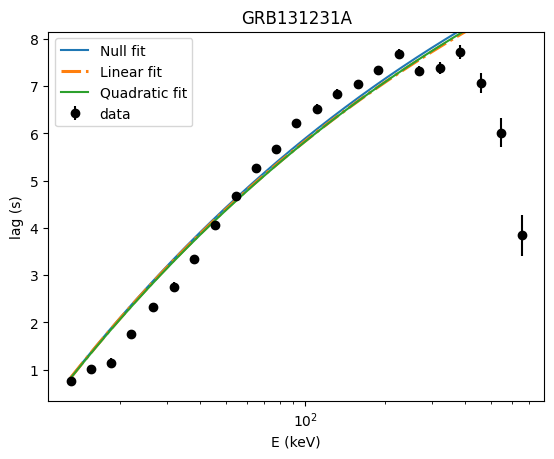

In [10]:
nplot = 1000
E = np.linspace(min(Erest), max(Erest), nplot)

plt.figure()
plt.errorbar(Erest, y, yerr, fmt='o', color='black', label='data')
plt.plot(E, null_fit, label='Null fit')
plt.plot(E, liv_lin_fit,label='Linear fit', ls='-.', lw = 2.2)
plt.plot(E, liv_quad_fit, label='Quadratic fit')
plt.xscale('log')
# plt.yscale('log')
plt.ylim(min(y) - max(abs(yerr)), max(y) + max(abs(yerr)))
# plt.ylim(-200, 20)
plt.legend()
plt.xlabel('E (keV)')
plt.ylabel('lag (s)')
plt.title(grbname_wtht_ext)
# plt.savefig(os.getcwd() + '/outputs/fits/' + grbname_wtht_ext + '_fit_logE.png', facecolor='white')
plt.show()